<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/optimal_tank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal tank operation


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

Initialise module GitHub repository.

In [1]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
    !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
    !pip install cvxpy
    data_dir = '/content/CIVE_70019_70057/data/optimal_tank/'
    figure_dir = '/content/CIVE_70019_70057/data/figures'
else:
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/optimal_tank'
    figure_dir = '/home/bradw/workspace/CIVE_70019_70057/data/figures'

Cloning into 'CIVE_70019_70057'...
remote: Enumerating objects: 745, done.
remote: Counting objects: 100% (495/495), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 745 (delta 310), reused 443 (delta 275), pack-reused 250 (from 1)
Receiving objects: 100% (745/745), 11.04 MiB | 4.74 MiB/s, done.
Resolving deltas: 100% (460/460), done.


Load dependencies.

In [2]:
# Load packages
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Matplotlib parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Problem formulation
We consider a tank operation problem using a simplified (and convex) model.

The system has a single tank, a single release, and a single (aggregated) demand point.

* $c_t$ is the variable water pumping/treatment cost associated with tank inflow at time $t \in \{0,\ldots,T-1\}$ (**known**)
* $S_{\text{max}}$ is the tank storage capacity (**known**)
* $S_0$ is the initial storage (**known**)
* $I_{max}$ is the maximum tank inflow
* $d_t$ is the water demand at time $t \in \{0,\ldots,T-1\}$ (**known**)
* $S_t$ is the tank storage at time $t \in \{0,\ldots,T\}$ (**state** variable)
* $I_t$ is the tank inflow at time $t \in \{0,\ldots,T-1\}$ (**control** variable)     

Load problem data.

In [3]:
data_name = 'tank_operation_data.mat'
data = scipy.io.loadmat(os.path.join(data_dir, data_name))

I_max = data['I_max'][0][0] # max tank inflow
d = data['d'] # water demand across time steps
S_max =  data['S_cap'][0][0] # tank storage capacity
S_init =  data['S_ini'][0][0] # initial storage level
T =  data['T'][0][0] # number of time steps
c = data['c'] # variable pumping/treatment cost
S_min = 0 # min storage level

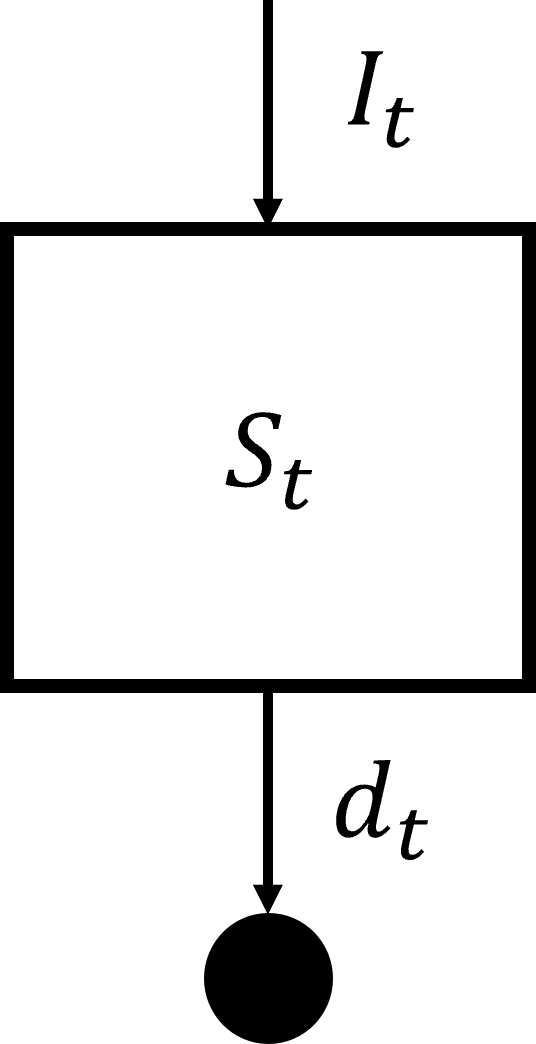

In [4]:
# problem figure
from IPython.display import Image, display
display(Image(filename=os.path.join(figure_dir, 'tank_illustration.png'), width=150))

Our optimisation problem aims to minimise water pumping/treatment cost, given by

$$\sum_{t=0}^{T-1} c_t I_t.$$

The problem is subject to mass balance constraints

$$S_{t+1} = S_t + I_t - d_t, \quad t=0,\ldots,T-1,$$

and physical constraints:

$$S_1 = S_0,$$
$$S_{min} \leq S \leq S_{max}, \quad t=0,\ldots,T,$$
$$0 \leq I \leq I_{max}, \quad t=0,\ldots,T-1.$$

### CVXPY solver

We solve this problem using CVXPY.

In [8]:
# define variables
S = cp.Variable(T+1) # storage
I = cp.Variable(T) # inflow

# objective function
objective = cp.Minimize( c.T @ I )

# constraints
constraint1 = [S[0] == S_init, S[T] >= S_min, S[T] <= S_max, S[T] == S_init]
constraint2 = []
constraint3 = []
constraint4 = []

for t in range(T):
    constraint2 += [S[t+1] == S[t] + I[t] - d[t] ]
    constraint3 += [S[t] >= S_min, S[t] <= S_max]
    constraint4 += [I[t] >= 0, I[t] <= I_max]

constraints = constraint1 + constraint2 + constraint3 + constraint4

# pass the problem to cvxpy
prob = cp.Problem(objective, constraints)

# compute optimal objective value
obj_value = prob.solve(solver=cp.CLARABEL, verbose=True)
print(obj_value)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 24 07:07:09 AM: Your problem has 49 variables, 124 constraints, and 0 parameters.
(CVXPY) Oct 24 07:07:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 24 07:07:09 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 24 07:07:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 24 07:07:09 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 24 07:07:09 AM: Compiling problem (target solver=CLARABEL)

Results plotting.

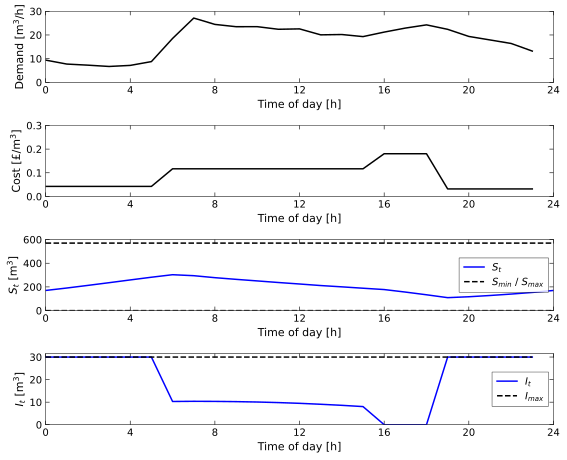

In [9]:
from matplotlib import rc
rc('text', usetex=False)

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize


fig, axs = plt.subplots(4, 1, figsize=(8, 6.5))

axs[0].plot(d, linewidth=1.5, color='black')
axs[0].set_yticks(np.arange(0, np.ceil(np.max(d) / 10) * 10 + 10, 10))
axs[0].set_xlabel('Time of day [h]')
axs[0].set_ylabel('Demand [$\mathrm{m}^3$/h]')

axs[1].plot(c, linewidth=1.5, color='black')
axs[1].set_yticks(np.arange(0, np.ceil(np.max(c) / 0.1) * 0.1 + 0.1, 0.1))
axs[1].set_xlabel('Time of day [h]')
axs[1].set_ylabel('Cost [£/$\mathrm{m}^3$]')

axs[2].plot(S.value, linewidth=1.5, label='$S_t$', color='blue')
axs[2].plot(S_min * np.ones([np.size(S)]), linewidth=1.5, label='$S_{min}$ / $S_{max}$', color='black', linestyle='--')
axs[2].plot(S_max * np.ones([np.size(S)]), linewidth=1.5, color='black', linestyle='--')
axs[2].set_yticks(np.arange(0, np.ceil(S_max / 100) * 100 + 100, 200))
axs[2].set_xlabel('Time of day [h]')
axs[2].set_ylabel('$S_t$ [$\mathrm{m}^3$]')
leg = axs[2].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

axs[3].plot(I.value, linewidth=1.5, label='$I_t$', color='blue')
axs[3].plot(I_max * np.ones([np.size(I)]), linewidth=1.5, label='$I_{max}$', color='black', linestyle='--')
axs[3].set_yticks(np.arange(0, np.ceil(I_max / 10) * 10 + 10, 10))
axs[3].set_xlabel('Time of day [h]')
axs[3].set_ylabel('$I_t$ [$\mathrm{m}^3$]')
leg = axs[3].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

for i in range(4):
    axs[i].set_xlim([0,T])
    axs[i].set_ylim(bottom=0)
    axs[i].set_xticks(np.arange(0, T+1, 4))
    axs[i].tick_params(axis="both", direction="in", length=4, width=0.6)
    axs[i].tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(0.5)

fig.tight_layout()
plt.show()

### Regularisation

Our new objective is to minimise water pumping/treatment cost **AND** changes in tank inflow $I_t$ between consecutive time steps. We include the latter objective using a regularisation term with penalty parameter $\lambda \geq 0$, as follows

$$\sum_{t=0}^{T-1} c_t I_t + \lambda \sum_{t=0}^{T-2} |I_{t+1} - I_t|.$$

The same physical constraints as the first problem are applied.


We solve this problem using CVXPY.

In [11]:
# define parameters
lamda_pen = 1e-1

# define variables
S = cp.Variable(T+1) # storage
I = cp.Variable(T) # inflow

# objective function
objective = cp.Minimize( c.T @ I + lamda_pen * cp.norm(I[1:T] - I[0:T-1], 1))

# constraints
constraint1 = [S[0] == S_init, S[T] >= S_min, S[T] <= S_max, S[T] == S_init]
constraint2 = []
constraint3 = []
constraint4 = []

for t in range(T):
    constraint2 += [S[t+1] == S[t] + I[t] - d[t] ]
    constraint3 += [S[t] >= S_min, S[t] <= S_max]
    constraint4 += [I[t] >= 0, I[t] <= I_max]

constraint5 = []
# constraint5 = [S[T] == S_init]

constraints = constraint1 + constraint2 + constraint3 + constraint4 + constraint5

# pass the problem to cvxpy
prob = cp.Problem(objective, constraints)

# compute optimal objective value
obj_value = prob.solve(solver=cp.CLARABEL, verbose=True)
print(obj_value)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 24 07:08:16 AM: Your problem has 49 variables, 124 constraints, and 0 parameters.
(CVXPY) Oct 24 07:08:16 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 24 07:08:16 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 24 07:08:16 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 24 07:08:16 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 24 07:08:16 AM: Compiling problem (target solver=CLARABEL)

Results plotting.

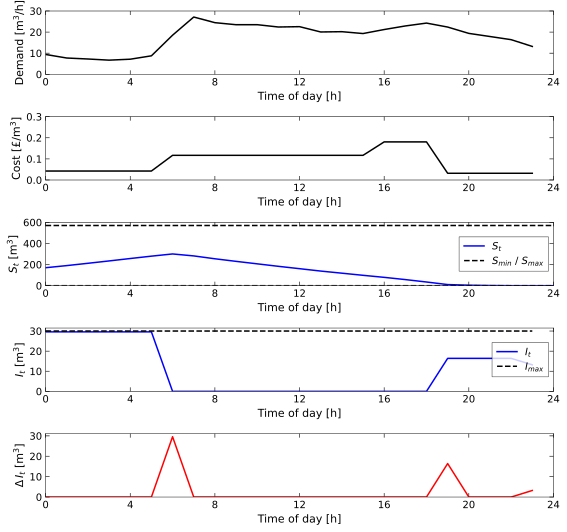

In [ ]:
from matplotlib import rc
rc('text', usetex=False)

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize


fig, axs = plt.subplots(5, 1, figsize=(8, 7.5))

axs[0].plot(d, linewidth=1.5, color='black')
axs[0].set_yticks(np.arange(0, np.ceil(np.max(d) / 10) * 10 + 10, 10))
axs[0].set_xlabel('Time of day [h]')
axs[0].set_ylabel('Demand [$\mathrm{m}^3$/h]')

axs[1].plot(c, linewidth=1.5, color='black')
axs[1].set_yticks(np.arange(0, np.ceil(np.max(c) / 0.1) * 0.1 + 0.1, 0.1))
axs[1].set_xlabel('Time of day [h]')
axs[1].set_ylabel('Cost [£/$\mathrm{m}^3$]')

axs[2].plot(S.value, linewidth=1.5, label='$S_t$', color='blue')
axs[2].plot(S_min * np.ones([np.size(S)]), linewidth=1.5, label='$S_{min}$ / $S_{max}$', color='black', linestyle='--')
axs[2].plot(S_max * np.ones([np.size(S)]), linewidth=1.5, color='black', linestyle='--')
axs[2].set_yticks(np.arange(0, np.ceil(S_max / 100) * 100 + 100, 200))
axs[2].set_xlabel('Time of day [h]')
axs[2].set_ylabel('$S_t$ [$\mathrm{m}^3$]')
leg = axs[2].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

axs[3].plot(I.value, linewidth=1.5, label='$I_t$', color='blue')
axs[3].plot(I_max * np.ones([np.size(I)]), linewidth=1.5, label='$I_{max}$', color='black', linestyle='--')
axs[3].set_yticks(np.arange(0, np.ceil(I_max / 10) * 10 + 10, 10))
axs[3].set_xlabel('Time of day [h]')
axs[3].set_ylabel('$I_t$ [$\mathrm{m}^3$]')
leg = axs[3].legend(loc='right',edgecolor='k',borderpad=0.5,fancybox=False)
leg.get_frame().set_linewidth(0.5)

I_delta = np.vstack((np.array([0]), np.array([np.abs(I.value[t+1] - I.value[t]) for t in np.arange(0, T-1)]).reshape(-1, 1)))
axs[4].plot(I_delta, linewidth=1.5, label='$I_t$', color='red')
axs[4].set_yticks(np.arange(0, np.ceil(np.max(I_delta) / 10) * 10 + 10, 10))
axs[4].set_xlabel('Time of day [h]')
axs[4].set_ylabel('$\Delta \, I_t$ [$\mathrm{m}^3$]')

for i in range(5):
    axs[i].set_xlim([0,T])
    axs[i].set_ylim(bottom=0)
    axs[i].set_xticks(np.arange(0, T+1, 4))
    axs[i].tick_params(axis="both", direction="in", length=4, width=0.6)
    axs[i].tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)
    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(0.5)

fig.tight_layout()
plt.show()

**Discussion:** what happens to the solution when we change the value of penalty parameter $\lambda$?